## Demonstrating the DemandComponent Class
This notebook demonstrates how to use the `DemandComponent` class for scenario building in energy systems. We will showcase demand scenarios with:\
(a) Annual demand specified\
(b) Annual demand with a subannual demand profile\
(c) Annual and flexible demand specified

### 1. Import and Setup
First, import the class and set up a clean output directory for the demonstration.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

### 2. Scenario Setup
We will use the same regions, fuels, and time scale for both scenarios. The time scale will span 20 years.

In [2]:
import shutil
from pyoscomp.scenario.components.base import ScenarioComponent
from pyoscomp.scenario.components.demand import DemandComponent

# Set up a clean demo output directory
DEMO_DIR = "demo_output/demand_component"
if os.path.exists(DEMO_DIR):
    shutil.rmtree(DEMO_DIR)
os.makedirs(DEMO_DIR, exist_ok=True)

In [3]:
# Common parameters for all scenarios
regions = ["North", "South", "East", "West"]
fuels = ["Electricity", "NaturalGas"]

### 3. Scenario 1: Annual Demand

In [4]:
# --- Scenario 1: Annual Demand ---
scenario1_dir = os.path.join(DEMO_DIR, "scenario1")
os.makedirs(scenario1_dir, exist_ok=True)

# Copy time component prerequisite from existing scenario (see demo.time.ipynb)
ScenarioComponent.copy("demo_output/time_component/uniform", scenario1_dir, overwrite=True)

# Copy topology component prerequisite from existing scenario (see demo.topology.ipynb)
ScenarioComponent.copy("demo_output/topology_component/custom", scenario1_dir, overwrite=False)

scenario1 = DemandComponent(scenario1_dir)
# Add demand for each region and fuel with different interpolation types
for i, region in enumerate(regions):
    for j, fuel in enumerate(fuels):
        # Set trajectory (i.e. known demand values at specific years)
        trajectory = {
            2025: 1000 + 500*i + 250*j,
            2040: 3000 + 500*i + 250*j
        }
        # Set interpolation method between known values
        interp_options = ["linear", "cagr", "step"]
        interp = interp_options[(i + j) % 3]
        # Alternatively, define a function to compute demand 
        def demand_estimate(year, base=1000+500*i+250*j):
            return base * (1.05 ** (year - 2025))

        # Add annual demand to the component
        scenario1.add_annual_demand(region, fuel, trajectory=trajectory, interpolation=interp) # use this for interpolation-based demand
        # scenario1.add_annual_demand(region, fuel, trajectory=trajectory, trend_function=demand_estimate) # use this for function-based demand
        # Note: Uncomment one of the above lines based on desired method
        # If both are provided in the same add_annual_demand() call, trend_function takes precedence
        # If add_annual_demand() is called multiple times for the same region-fuel, the last call overwrites previous entries

# Process and save the scenario
scenario1.process()
scenario1.save()

# Display the generated DataFrame
print("Annual Demand (Scenario 1):")
print(scenario1.annual_demand_df.head())

Annual Demand (Scenario 1):
  REGION         FUEL  YEAR        VALUE
0  North  Electricity  2025  1000.000000
1  North  Electricity  2030  1666.666667
2  North  Electricity  2035  2333.333333
3  North  Electricity  2040  3000.000000
4  North  Electricity  2045  3666.666667


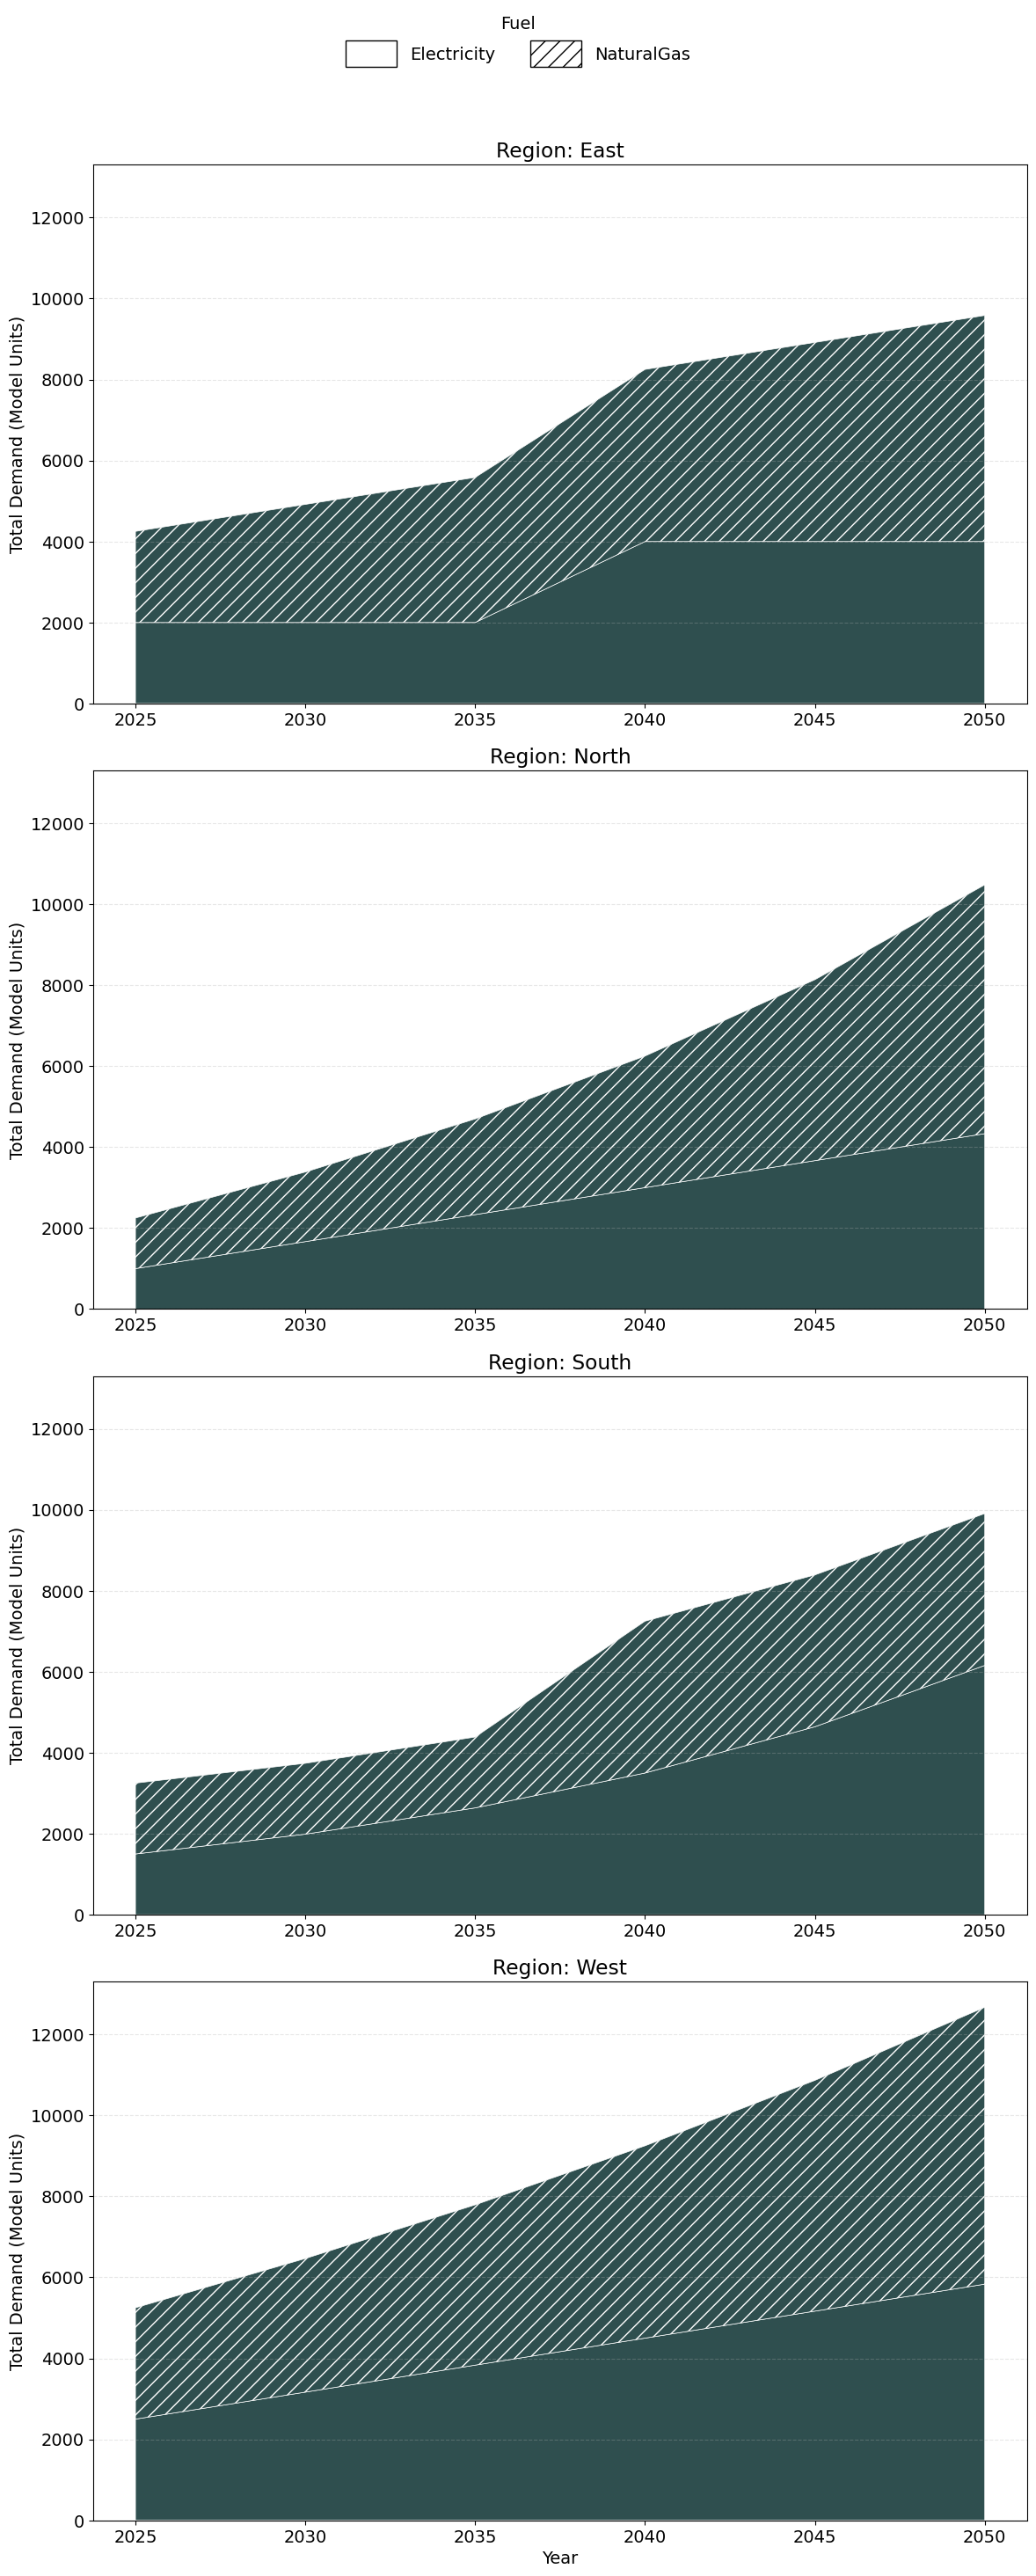

In [5]:
scenario1.visualize_all()

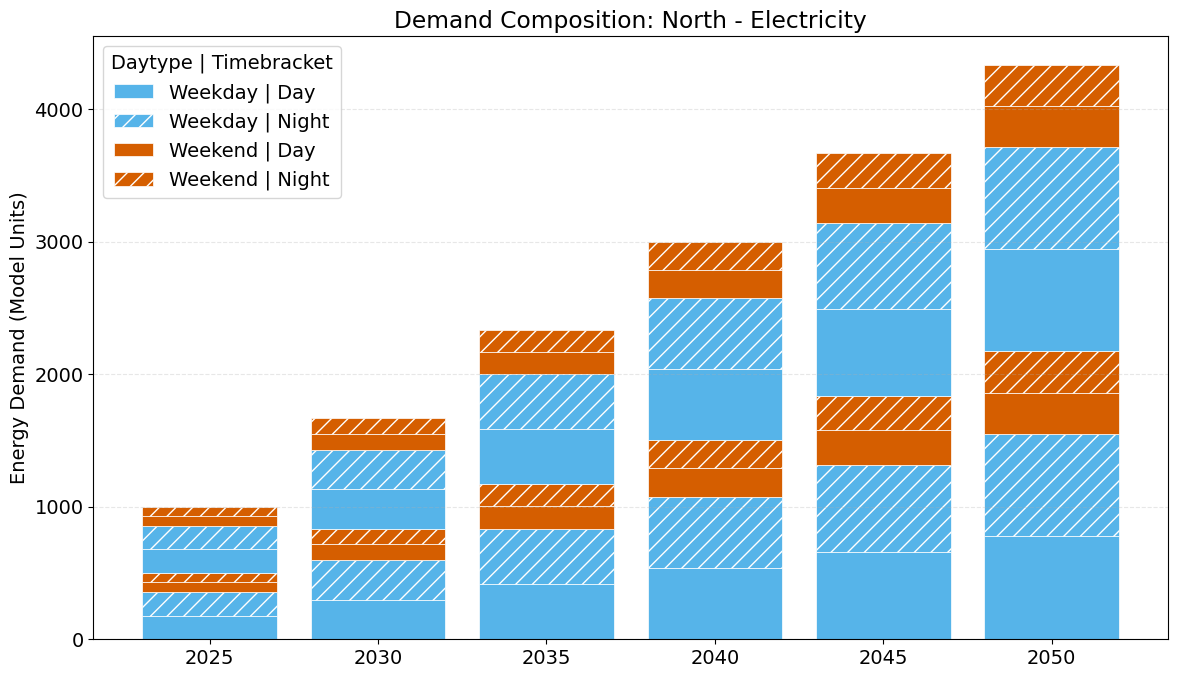

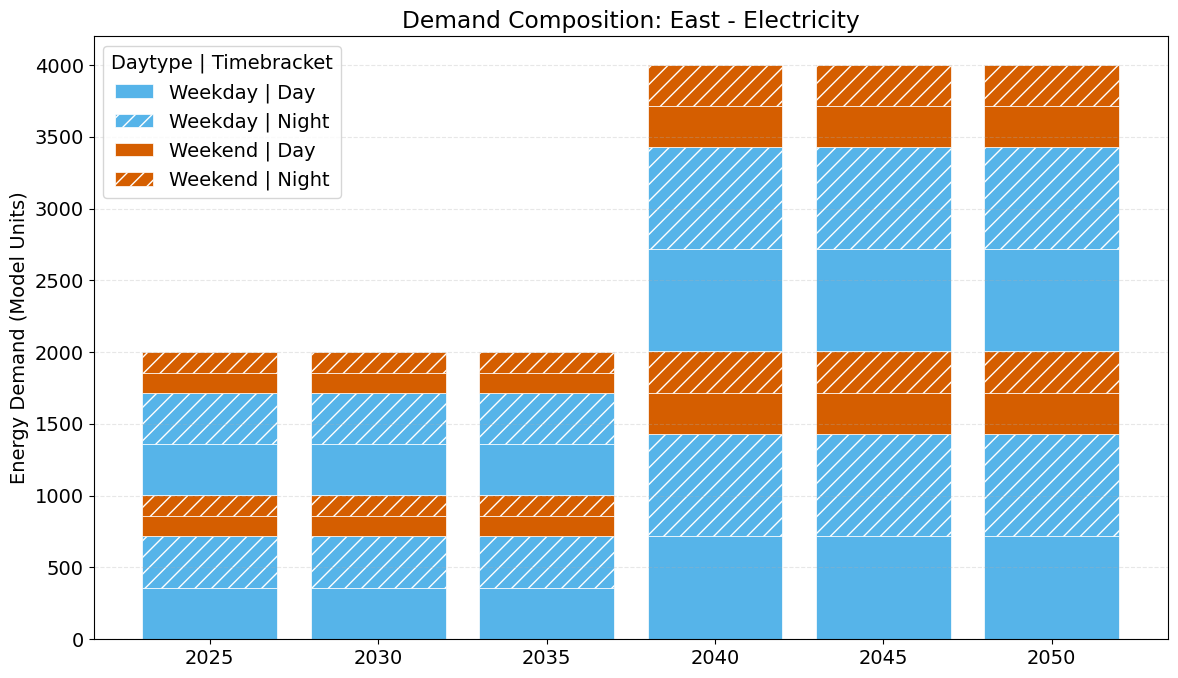

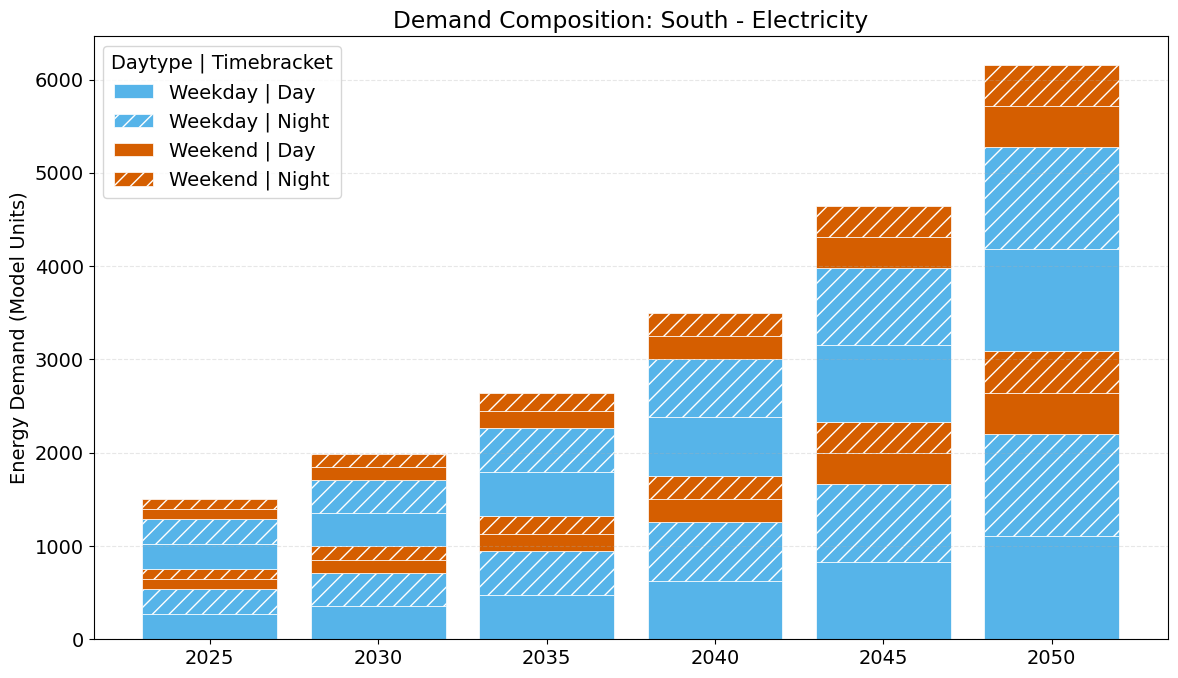

In [6]:
scenario1.visualize(region="North", fuel="Electricity")
scenario1.visualize(region="East", fuel="Electricity")
scenario1.visualize(region="South", fuel="Electricity")

### 4. Scenario 2: Annual and Subannual Demand

In [7]:
# --- Scenario 2: Annual + Subannual Demand ---
scenario2_dir = os.path.join(DEMO_DIR, "scenario2")
os.makedirs(scenario2_dir, exist_ok=True)

# Copy demand component from scenario 1 as base
ScenarioComponent.copy(scenario1_dir, scenario2_dir, overwrite=True)

sample_timeslices = ["Summer_Weekend_Day", "Summer_Weekend_Night",
                     "Winter_Weekend_Day", "Winter_Weekend_Night"]

scenario2 = DemandComponent(scenario2_dir)
scenario2.load()
# Set demand profile for each region and fuel
for i, region in enumerate(regions):
    for j, fuel in enumerate(fuels):
        # Set subannual demand profile by timeslice factors
        timeslice_factors = {
            ts: ((i + 2*j) % 4) / 3.0 for ts in sample_timeslices
        }
        # Alternatively, set subannual demand profile by season/day/time factors
        time_factors = {"Day": 1.5, "Night": 0.5}

        # Set subannual profile
        scenario2.set_subannual_profile(region, fuel, timeslice_factor=timeslice_factors)
        scenario2.set_subannual_profile(region, fuel, year=2025,
            season_factor={"Summer": 1.2, "Winter": 0.8}, time_factor=time_factors)
        scenario2.set_subannual_profile(region, fuel, year=2040,
            season_factor={"Summer": 1.4, "Winter": 0.6}, time_factor=time_factors)
        # Note: Uncomment any of the above lines based on desired method
        # If both are provided in the same set_subannual_profile() call, timeslice_factor takes precedence
        # If set_subannual_profile() is called multiple times for the same region-fuel-year combination, the last call overwrites previous entries

scenario2.process()
scenario2.save()

# Display the generated DataFrame
print("Subannual Demand (Scenario 2):")
print(scenario2.profile_demand_df.head())

Subannual Demand (Scenario 2):
  REGION         FUEL             TIMESLICE  YEAR     VALUE
0  North  Electricity    Winter_Weekday_Day  2025  0.213582
1  North  Electricity  Winter_Weekday_Night  2025  0.071194
2  North  Electricity    Winter_Weekend_Day  2025  0.085433
3  North  Electricity  Winter_Weekend_Night  2025  0.028478
4  North  Electricity    Summer_Weekday_Day  2025  0.322133


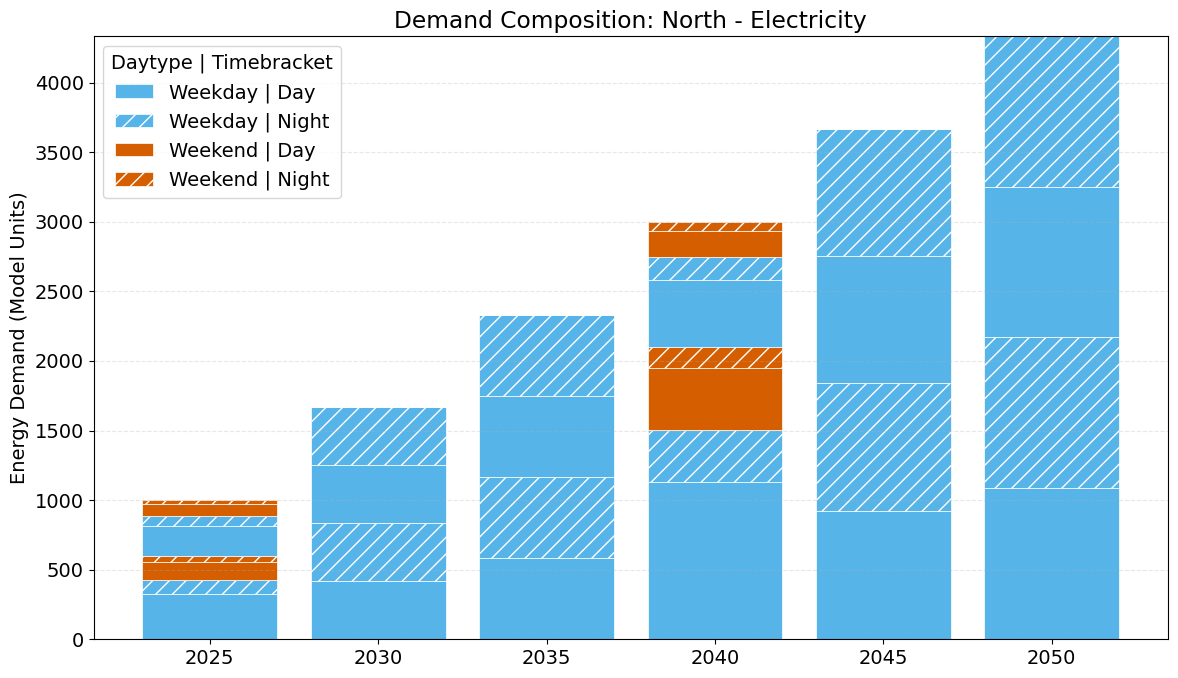

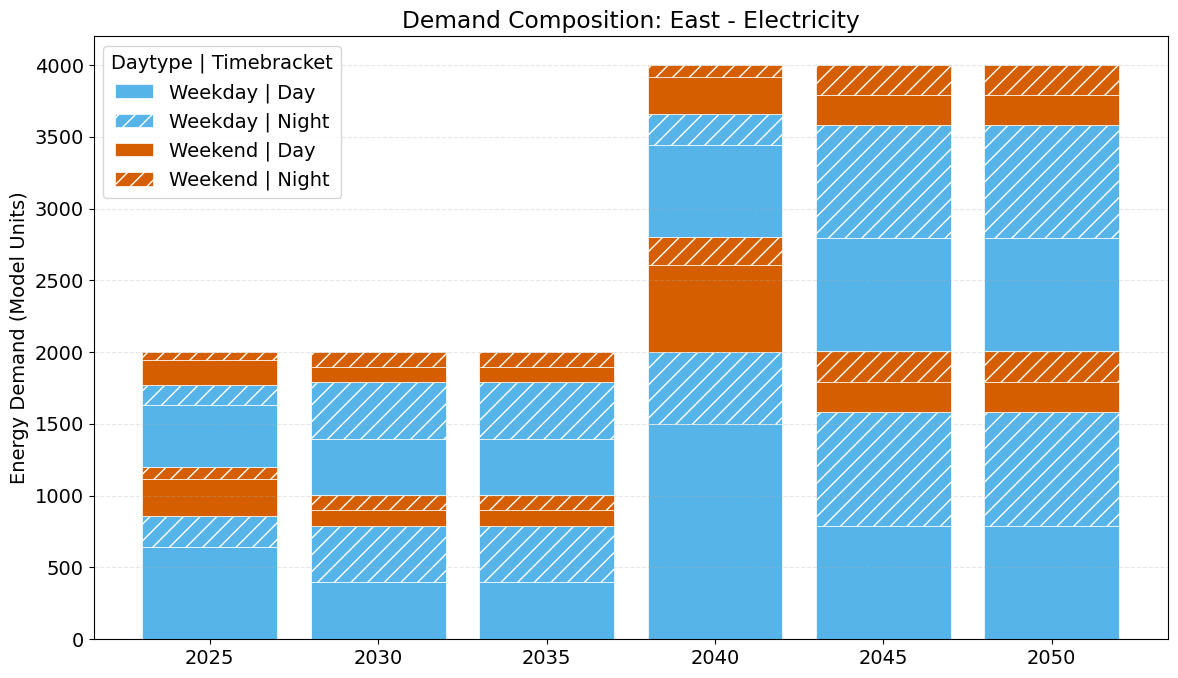

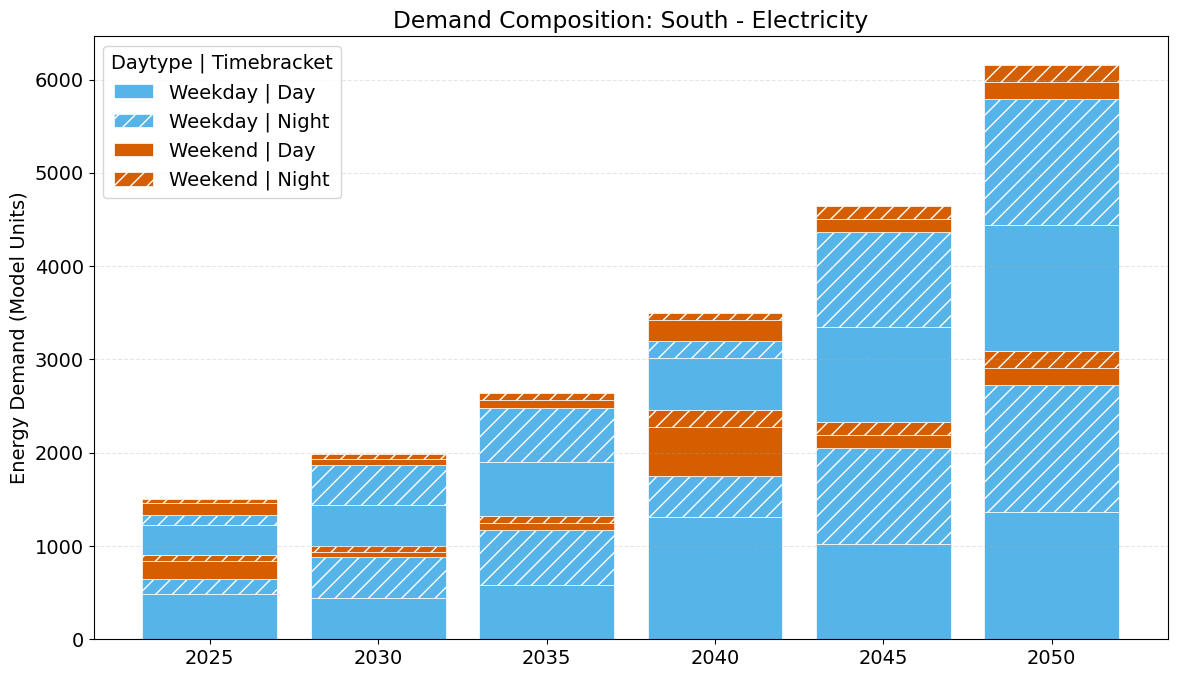

In [8]:
scenario2.visualize(region="North", fuel="Electricity")
scenario2.visualize(region="East", fuel="Electricity")
scenario2.visualize(region="South", fuel="Electricity")

### 5. Scenario 3: Annual, Subannual, and Flexible Demand

In [9]:
# TODO: visualize_all() should include flexible demand hatched (use HATCHES[::-1])
# TODO: visualize() should include flexible demand in grey with legend